# In this notebook I analyze sample marketing data to...

### Identify the ideal lead,

### Predict response,

### Optimize lead selection,

### Maximize profit,

# And turn a losing marketing campaign into a winner!

### Scroll through to see results :)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import plot_importance
pd.set_option('display.max_columns', None)

In [2]:
# Read into dataframe
df = pd.read_csv(r'C:\Users\caleb\Downloads\kaggle_marketing_dataset\marketing_campaign.csv', sep=';')

# Rename columns for ease of coding
for col in df.columns:
    df.rename(columns={col:col.lower()}, inplace=True)
    
print('Total Records: %s' % len(df))

# Age of lead
df['age'] = 2025 - df['year_birth']

# Revenue from marketing campaign
df['new_revenue'] = 0
df.loc[df['response'] == 1, 'new_revenue'] = 11

# Total past revenue from lead
df['past_revenue'] = df['mntwines'] + df['mntfruits'] + df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

# Total past responses from lead
df['responses'] = df['acceptedcmp1'] + df['acceptedcmp2'] + df['acceptedcmp3'] + df['acceptedcmp4'] + df['acceptedcmp5']

# Has the lead ever responded before?
df['responded'] = 0
df.loc[df['responses'] > 0, 'responded'] = 1

# Total past purchases from lead
df['purchases'] = df['numwebpurchases'] + df['numcatalogpurchases'] + df['numstorepurchases'] + df['numdealspurchases']

# Profit from marketing campaign
df['profit'] = df['new_revenue'] - df['z_costcontact']

# Display data
df.head()

Total Records: 2240


,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response,age,new_revenue,past_revenue,responses,responded,purchases,profit
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,68,11,1617,0,0,25,8
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,71,0,27,0,0,6,-3
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,60,0,776,0,0,21,-3
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,41,0,53,0,0,8,-3
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,44,0,422,0,0,19,-3


# Identify the ideal lead

In [3]:
print('Average Income of Responders: %s' % (df['income'][df['responded'] == 1].mean()))
print('Average Age of Responders: %s' % (df['age'][df['responded'] == 1].mean()))
print('Average # of Young Children of Responders: %s' % (df['kidhome'][df['responded'] == 1].mean()))
print('Average # of Teen Children of Responders: %s' % (df['teenhome'][df['responded'] == 1].mean()))
print('Average # of Teen Children of Responders: %s' % (df['teenhome'][df['responded'] == 1].mean()))

Average Income of Responders: 65255.58387799564
Average Age of Responders: 56.92008639308855
Average # of Young Children of Responders: 0.22894168466522677
Average # of Teen Children of Responders: 0.39956803455723544
Average # of Teen Children of Responders: 0.39956803455723544


In [4]:
mean_cols = ['response', 'responses', 'responded', 'purchases', 'past_revenue', 'profit', 'complain']

In [5]:
# Summary by Education level

group = ['education']

catc = df[group + ['id']].groupby(group).count().sort_values(by=['id'], ascending=[False]).reset_index()

catc['contacted_distribution'] = catc['id'] / catc['id'].sum()

catm = df[group + mean_cols].groupby(group).mean().reset_index()

cat = catc.merge(catm, how='inner', on=group)

cat['avg_purchase_value'] = cat['past_revenue'] / cat['purchases']

cat.rename(columns={'id':'contacted_num'
                    ,'response':'response_rate'
                    ,'responded':'pct_past_customers'
                    ,'responses':'past_response_rate'
                    ,'purchases':'avg_past_purchases'
                    ,'past_revenue':'avg_past_revenue'
                    ,'profit':'avg_profit_per_lead'
                    ,'complain':'complaint_rate'}, inplace=True)

cat

,education,contacted_num,contacted_distribution,response_rate,past_response_rate,pct_past_customers,avg_past_purchases,avg_past_revenue,avg_profit_per_lead,complaint_rate,avg_purchase_value
0,Graduation,1127,0.503125,0.134871,0.304348,0.204082,14.990240,619.898846,-1.516415,0.012422,41.353498
1,PhD,486,0.216964,0.207819,0.337449,0.234568,15.829218,672.409465,-0.713992,0.002058,42.479007
2,Master,370,0.165179,0.154054,0.278378,0.202703,14.927027,611.781081,-1.305405,0.005405,40.984791
3,2n Cycle,203,0.090625,0.108374,0.251232,0.187192,13.802956,496.527094,-1.807882,0.019704,35.972520
4,Basic,54,0.024107,0.037037,0.111111,0.111111,7.018519,81.796296,-2.592593,0.000000,11.654354


In [6]:
# Summary by marital status

group = ['marital_status']

catc = df[group + ['id']].groupby(group).count().sort_values(by=['id'], ascending=[False]).reset_index()

catc['contacted_distribution'] = catc['id'] / catc['id'].sum()

catm = df[group + mean_cols].groupby(group).mean().reset_index()

cat = catc.merge(catm, how='inner', on=group)

cat['avg_purchase_value'] = cat['past_revenue'] / cat['purchases']

cat.rename(columns={'id':'contacted_num'
                    ,'response':'response_rate'
                    ,'responded':'pct_past_customers'
                    ,'responses':'past_response_rate'
                    ,'purchases':'avg_past_purchases'
                    ,'past_revenue':'avg_past_revenue'
                    ,'profit':'avg_profit_per_lead'
                    ,'complain':'complaint_rate'}, inplace=True)

cat

,marital_status,contacted_num,contacted_distribution,response_rate,past_response_rate,pct_past_customers,avg_past_purchases,avg_past_revenue,avg_profit_per_lead,complaint_rate,avg_purchase_value
0,Married,864,0.385714,0.113426,0.303241,0.210648,14.956019,590.802083,-1.752315,0.009259,39.502631
1,Together,580,0.258929,0.103448,0.289655,0.200000,14.817241,608.387931,-1.862069,0.008621,41.059460
2,Single,480,0.214286,0.220833,0.287500,0.204167,14.243750,606.483333,-0.570833,0.012500,42.578909
3,Divorced,232,0.103571,0.206897,0.293103,0.198276,15.237069,610.629310,-0.724138,0.008621,40.075248
4,Widow,77,0.034375,0.246753,0.363636,0.246753,16.701299,738.818182,-0.285714,0.000000,44.237170
5,Alone,3,0.001339,0.333333,0.333333,0.333333,13.333333,256.666667,0.666667,0.000000,19.250000
6,Absurd,2,0.000893,0.500000,1.000000,0.500000,19.500000,1192.500000,2.500000,0.000000,61.153846
7,YOLO,2,0.000893,0.500000,0.000000,0.000000,19.000000,424.000000,2.500000,0.000000,22.315789


In [7]:
# Summary by number of young children

group = ['kidhome']

catc = df[group + ['id']].groupby(group).count().sort_values(by=['id'], ascending=[False]).reset_index()

catc['contacted_distribution'] = catc['id'] / catc['id'].sum()

catm = df[group + mean_cols].groupby(group).mean().reset_index()

cat = catc.merge(catm, how='inner', on=group)

cat['avg_purchase_value'] = cat['past_revenue'] / cat['purchases']

cat.rename(columns={'id':'contacted_num'
                    ,'response':'response_rate'
                    ,'responded':'pct_past_customers'
                    ,'responses':'past_response_rate'
                    ,'purchases':'avg_past_purchases'
                    ,'past_revenue':'avg_past_revenue'
                    ,'profit':'avg_profit_per_lead'
                    ,'complain':'complaint_rate'}, inplace=True)

cat

,kidhome,contacted_num,contacted_distribution,response_rate,past_response_rate,pct_past_customers,avg_past_purchases,avg_past_revenue,avg_profit_per_lead,complaint_rate,avg_purchase_value
0,0,1293,0.577232,0.171694,0.423047,0.278422,18.093581,901.260634,-1.111369,0.006187,49.811071
1,1,899,0.401339,0.122358,0.130145,0.111235,10.486096,205.434928,-1.654060,0.013348,19.591174
2,2,48,0.021429,0.041667,0.062500,0.062500,9.770833,145.250000,-2.541667,0.020833,14.865672


In [8]:
# Summary by # teenage children in home

group = ['teenhome']

catc = df[group + ['id']].groupby(group).count().sort_values(by=['id'], ascending=[False]).reset_index()

catc['contacted_distribution'] = catc['id'] / catc['id'].sum()

catm = df[group + mean_cols].groupby(group).mean().reset_index()

cat = catc.merge(catm, how='inner', on=group)

cat['avg_purchase_value'] = cat['past_revenue'] / cat['purchases']

cat.rename(columns={'id':'contacted_num'
                    ,'response':'response_rate'
                    ,'responded':'pct_past_customers'
                    ,'responses':'past_response_rate'
                    ,'purchases':'avg_past_purchases'
                    ,'past_revenue':'avg_past_revenue'
                    ,'profit':'avg_profit_per_lead'
                    ,'complain':'complaint_rate'}, inplace=True)

cat

,teenhome,contacted_num,contacted_distribution,response_rate,past_response_rate,pct_past_customers,avg_past_purchases,avg_past_revenue,avg_profit_per_lead,complaint_rate,avg_purchase_value
0,0,1158,0.516964,0.204663,0.389465,0.249568,13.879102,692.798791,-0.748705,0.009499,49.916687
1,1,1030,0.459821,0.089320,0.194175,0.158252,15.862136,508.826214,-2.017476,0.008738,32.078039
2,2,52,0.023214,0.096154,0.307692,0.211538,16.942308,589.153846,-1.942308,0.019231,34.774120


#### Ideal lead is a 56 year old, widowed PHd with no kids and the U.S. average income

## Predict response

Training Score: 0.8485988602570348
Test Score: 0.8589140909625103


,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response,age,new_revenue,past_revenue,responses,responded,purchases,profit,resp_prob
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,68,11,1617,0,0,25,8,0.200468
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,71,0,27,0,0,6,-3,0.041373
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,60,0,776,0,0,21,-3,0.031584
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,41,0,53,0,0,8,-3,0.029367
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,44,0,422,0,0,19,-3,0.031187


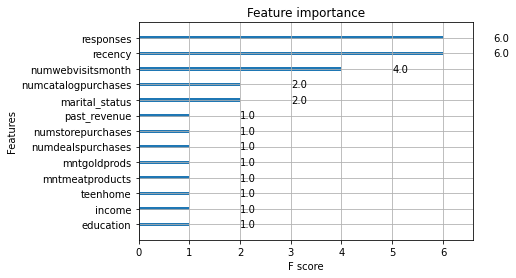

In [9]:
# Define feature list
features = df.columns.drop(['id', 'response', 'dt_customer', 'z_costcontact', 'z_revenue'
                            ,'responded', 'profit', 'new_revenue']).tolist()

# Split into training and test datasets
from sklearn.model_selection import train_test_split

x =  df[['id'] + features]
y = df['response']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=8)

# Grab IDs to identify training and test populations later
test_ids = x_test['id']
x_test.drop(columns=['id'], inplace=True)
x_train.drop(columns=['id'], inplace=True)

# Build a pipeline of training
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8))
]

pipe = Pipeline(steps=estimators)

# Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth' : Integer(2, 8),
    'clf__learning_rate' : Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample' : Real(0.5, 1.0),
    'clf__colsample_bytree' : Real(0.5, 1.0),
    'clf__colsample_bylevel' : Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha' : Real(0.0, 10.0),
    'clf__reg_lambda' : Real(0.0, 10.0),
    'clf__gamma' : Real(0.0, 10.0)  
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8)

# Train the model
opt.fit(x_train, y_train)

# Evaluate the model
opt.best_estimator_

print('Training Score: %s' % opt.best_score_)
print('Test Score: %s' % opt.score(x_test, y_test))

opt.best_estimator_.steps

# Plot feature importance
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

# Binary predictions
# opt.predict(x_test)

# Predict probability of both responding and not responding
# opt.predict_proba(x_test)

# Generate predicted probability of responding
df['resp_prob'] = opt.predict_proba(df[features])[:, 1]

df.head()

### Top 3 Predictors of Response:

#### 1. Number of responses to past marketing campaigns

#### 2. Number of days since last purchase

#### 3. Number of visits to company’s web site in the last month

## Optimize lead selection and maximize profit

In [10]:
# Tune with training population
train = df[~df['id'].isin(test_ids)]

# What minimum response score maximizes profit?
means = train[['resp_prob', 'response']].groupby(['resp_prob']).mean().reset_index()

means.rename(columns={'response':'response_rate'}, inplace=True)

sums = train[['resp_prob', 'response', 'z_costcontact', 'new_revenue', 'profit']].groupby(['resp_prob']).sum().reset_index()

sums.rename(columns={'response':'sales', 'z_costcontact':'cost', 'new_revenue':'revenue'}, inplace=True)

counts = train[['resp_prob', 'id']].groupby(['resp_prob']).count().reset_index()

counts.rename(columns={'id':'volume'}, inplace=True)

train_tune = counts.merge(means, how='inner', on=['resp_prob'])
train_tune = train_tune.merge(sums, how='inner', on=['resp_prob'])

train_tune.sort_values(by=['resp_prob'], ascending=[False], inplace=True)

train_tune['total_sales'] = train_tune['sales'].cumsum()
train_tune['total_cost'] = train_tune['cost'].cumsum()
train_tune['total_revenue'] = train_tune['revenue'].cumsum()
train_tune['total_profit'] = train_tune['profit'].cumsum()
train_tune['cost_per_sale'] = train_tune['total_cost'] / train_tune['total_sales']

train_tune.sort_values(by=['resp_prob'], ascending=[True], inplace=True)

threshold = train_tune['resp_prob'][train_tune['total_profit'] == train_tune['total_profit'].max()].reset_index(drop=True)[0]

train_tune[train_tune['total_profit'] == train_tune['total_profit'].max()]

,resp_prob,volume,response_rate,sales,cost,revenue,profit,total_sales,total_cost,total_revenue,total_profit,cost_per_sale
826,0.278175,1,1.0,1,3,11,8,164,795,1804,1009,4.847561


In [11]:
# Backtest on test population
test = df[df['id'].isin(test_ids)]

# Generate column for 1 = selected by response model, 0 = not selected
test['select'] = (test['resp_prob'] >= threshold).astype(int)

# What minimum response score would have maximized profit?
means = test[['resp_prob', 'response']].groupby(['resp_prob']).mean().reset_index()

means.rename(columns={'response':'response_rate'}, inplace=True)

sums = test[['resp_prob', 'response', 'z_costcontact', 'new_revenue', 'profit']].groupby(['resp_prob']).sum().reset_index()

sums.rename(columns={'response':'sales', 'z_costcontact':'cost', 'new_revenue':'revenue'}, inplace=True)

counts = test[['resp_prob', 'id']].groupby(['resp_prob']).count().reset_index()

counts.rename(columns={'id':'volume'}, inplace=True)

test_tune = counts.merge(means, how='inner', on=['resp_prob'])
test_tune = test_tune.merge(sums, how='inner', on=['resp_prob'])

test_tune.sort_values(by=['resp_prob'], ascending=[False], inplace=True)

test_tune['total_sales'] = test_tune['sales'].cumsum()
test_tune['total_cost'] = test_tune['cost'].cumsum()
test_tune['total_revenue'] = test_tune['revenue'].cumsum()
test_tune['total_profit'] = test_tune['profit'].cumsum()
test_tune['cost_per_sale'] = test_tune['total_cost'] / test_tune['total_sales']

test_tune.sort_values(by=['resp_prob'], ascending=[True], inplace=True)

threshold = test_tune['resp_prob'][test_tune['total_profit'] == test_tune['total_profit'].max()].reset_index(drop=True)[0]

test_tune[test_tune['total_profit'] == test_tune['total_profit'].max()]

C:\Users\caleb\AppData\Local\Temp\ipykernel_4832\4209657791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['select'] = (test['resp_prob'] >= threshold).astype(int)


,resp_prob,volume,response_rate,sales,cost,revenue,profit,total_sales,total_cost,total_revenue,total_profit,cost_per_sale
259,0.186149,1,1.0,1,3,11,8,52,366,572,206,7.038462


## RESULTS

In [24]:
unmodeled_num = len(test)
print('Unmodeled VOLUME: %s' % (unmodeled_num))
unmodeled_cost = test['z_costcontact'].sum()
print('Unmodeled COST: $%s' % (unmodeled_cost))
unmodeled_sales = test['response'].sum()
print('Unmodeled SALES: %s' % (unmodeled_sales))
unmodeled_revenue = test['new_revenue'].sum()
print('Unmodeled REVENUE: $%s' % (unmodeled_revenue))
unmodeled_profit = test['profit'].sum()
print('Unmodeled PROFIT: $%s' % (unmodeled_profit))
unmodeled_rr = (unmodeled_sales / unmodeled_num) * 100
print('Unmodeled RESPONSE RATE: %s%%' % round(unmodeled_rr, 2))
unmodeled_cac = round(test['z_costcontact'].sum() / test['response'].sum(), 2)
print('Unmodeled CUSTOMER ACQUISITION COST: $%s' % (unmodeled_cac))
unmodeled_roi = ((unmodeled_revenue - unmodeled_cost) / unmodeled_cost) * 100
print('Unmodeled RETURN ON INVESTMENT: %s%%' % round(unmodeled_roi, 2))

Unmodeled VOLUME: 448
Unmodeled COST: $1344
Unmodeled SALES: 67
Unmodeled REVENUE: $737
Unmodeled PROFIT: $-607
Unmodeled RESPONSE RATE: 14.96%
Unmodeled CUSTOMER ACQUISITION COST: $20.06
Unmodeled RETURN ON INVESTMENT: -45.16%


In [23]:
model_num = len(test[test['select'] == 1])
print('Modeled VOLUME: %s' % (model_num))
model_cost = test['z_costcontact'][test['select'] == 1].sum()
print('Modeled COST: $%s' % (model_cost))
model_sales = test['response'][test['select'] == 1].sum()
print('Modeled SALES: %s' % (model_sales))
model_revenue = test['new_revenue'][test['select'] == 1].sum()
print('Modeled REVENUE: $%s' % (model_revenue))
model_profit = test['profit'][test['select'] == 1].sum()
print('Modeled PROFIT: $%s' % (model_profit))
model_rr = (model_sales / model_num) * 100
print('Modeled RESPONSE RATE: %s%%' % round(model_rr, 2))
model_cac = round(test['z_costcontact'][test['select'] == 1].sum() / test['response'][test['select'] == 1].sum(), 2)
print('Modeled CUSTOMER ACQUISITION COST: $%s' % (model_cac))
model_roi = ((model_revenue - model_cost) / model_cost) * 100
print('Modeled RETURN ON INVESTMENT: %s%%' % round(model_roi, 2))

Modeled VOLUME: 61
Modeled COST: $183
Modeled SALES: 34
Modeled REVENUE: $374
Modeled PROFIT: $191
Modeled RESPONSE RATE: 55.74%
Modeled CUSTOMER ACQUISITION COST: $5.38
Modeled RETURN ON INVESTMENT: 104.37%


In [16]:
cac_lift = round((model_cac - unmodeled_cac) / unmodeled_cac * 100, 2)
print('Modeled Customer Acquisition Cost Decrease: %s%%' % (cac_lift))
profit_lift = round(abs((model_profit - unmodeled_profit) / unmodeled_profit * 100), 2)
print('Modeled Profit Increase: %s%%' % (profit_lift))

Modeled Customer Acquisition Cost Decrease: -73.18%
Modeled Profit Increase: 131.47%
